In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [26]:
import tensorflow as tf

In [27]:
#!unzip -q /content/pizza_steak_sushi.zip

In [28]:
base_dir = "/content/train"

In [29]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,rotation_range = 40,width_shift_range = 0.2,height_shift_range = 0.2,shear_range = 0.2,
    zoom_range = 0.2,horizontal_flip = True,fill_mode = "nearest" ,validation_split = 0.2
)
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,validation_split = 0.2)

train_generator = train_datagen.flow_from_directory(base_dir,target_size = (300,300),class_mode = "categorical",
                                                                  batch_size = 4,subset = "training",seed = 42)
validation_generator = validation_datagen.flow_from_directory(base_dir,target_size = (300,300),class_mode = "categorical",
                                                         batch_size =4,subset = "validation",seed = 42)

Found 181 images belonging to 3 classes.
Found 44 images belonging to 3 classes.


In [30]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (300,300,3),include_top = False,weights = "imagenet")
"""Freeze all layers to stop updating InceptionV3 trained weights."""
for layer in base_model.layers:
    layer.trainable = False

In [31]:
"""You can change it if you want."""
last_layer = base_model.get_layer("mixed8")
print(last_layer.output_shape)

(None, 8, 8, 1280)


In [32]:
import os 
classes = os.listdir(base_dir)
for i in range(len(classes)):
    path = os.path.join(base_dir,classes[i])
    print(f"{classes[i]} has {len(os.listdir(path))} images")

sushi has 72 images
pizza has 78 images
steak has 75 images


In [33]:
"""Flatten layer to reduce output shape to 1dim."""
x = tf.keras.layers.Flatten()(last_layer.output)
"""Add fully connected layers with 256 units."""
x = tf.keras.layers.Dense(256,activation = "relu")(x)
"""Add Dropout layer."""
x = tf.keras.layers.Dropout(0.2)(x)
"""Output layer."""
x = tf.keras.layers.Dense(len(classes),activation = "softmax")(x)
"""Here we can connect our model end to end."""
model = tf.keras.models.Model(base_model.input,x)

In [34]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [35]:
model.compile(tf.keras.optimizers.RMSprop(learning_rate = 0.005),loss = "categorical_crossentropy",metrics = ["acc"])
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs = {}):
        if logs.get("acc") > 0.95:
            print("Accuracy reached %95.Stop training.")
            self.model.stop_training = True 

callback = myCallback()

In [36]:
history = model.fit(train_generator,epochs = 30,batch_size = 4,validation_data = validation_generator,verbose = 1,
                   callbacks = [callback])

Epoch 1/30
46/46 [==============================] - 63s 1s/step - loss: 81.8965 - acc: 0.4641 - val_loss: 3.7992 - val_acc: 0.8409
Epoch 2/30
46/46 [==============================] - 56s 1s/step - loss: 15.6730 - acc: 0.6354 - val_loss: 1.7219 - val_acc: 0.8864
Epoch 3/30
46/46 [==============================] - 57s 1s/step - loss: 4.2233 - acc: 0.6961 - val_loss: 0.7431 - val_acc: 0.8636
Epoch 4/30
46/46 [==============================] - 56s 1s/step - loss: 2.8756 - acc: 0.7901 - val_loss: 1.3197 - val_acc: 0.8409
Epoch 5/30
46/46 [==============================] - 56s 1s/step - loss: 3.5675 - acc: 0.7790 - val_loss: 0.8262 - val_acc: 0.8636
Epoch 6/30
46/46 [==============================] - 56s 1s/step - loss: 1.6727 - acc: 0.7403 - val_loss: 0.8711 - val_acc: 0.7727
Epoch 7/30
46/46 [==============================] - 57s 1s/step - loss: 1.3955 - acc: 0.7901 - val_loss: 0.2908 - val_acc: 0.9091
Epoch 8/30
46/46 [==============================] - 55s 1s/step - loss: 2.7754 - acc: 0.

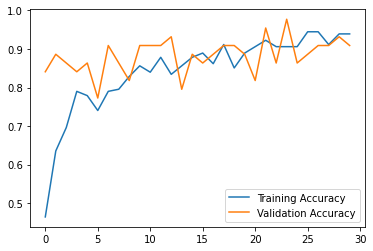

In [37]:
import matplotlib.pyplot as plt
"""Plot accuracy"""
acc = history.history["acc"]
val_acc = history.history["val_acc"]
epochs = range(30)
plt.plot(epochs,acc,label = "Training Accuracy")
plt.plot(epochs,val_acc,label = "Validation Accuracy")
plt.legend()
plt.show()

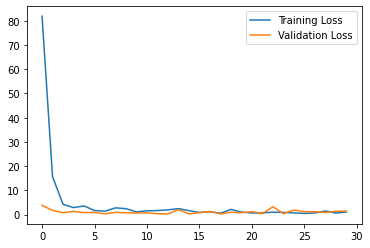

In [38]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(30)
plt.plot(epochs,loss,label = "Training Loss")
plt.plot(epochs,val_loss,label = "Validation Loss")
plt.legend()
plt.show()

In [40]:
model.save("pizza_steak_sushitfl.h5")
model1 = tf.keras.models.load_model("pizza_steak_sushitfl.h5")

In [41]:
from PIL import Image
import requests
from io import BytesIO
import numpy as np

def get_and_process(url):
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        img1 = img
        """Resize image for appropriate shape for model."""
        img = img.resize((300,300))
        """Convert img to numpy array,rescale it ,expand dims for model convenience. then check vertically."""
        x = tf.keras.preprocessing.image.img_to_array(img)
        x = x / 255.0
        x = np.expand_dims(x,axis = 0)
        img_tensor = np.vstack([x])
        return img1,img_tensor

Prediction is : steak


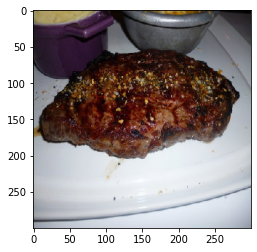

In [54]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
#url = "https://images.unsplash.com/photo-1600891964092-4316c288032e?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxzZWFyY2h8Mnx8c3RlYWt8ZW58MHx8MHx8&w=1000&q=80"
#img1,test_img = get_and_process(url)
img1 = keras.preprocessing.image.load_img(
    "/content/train/steak/1761285.jpg", target_size=(300,300)
)
test_img = keras.preprocessing.image.img_to_array(img1)
test_img = tf.expand_dims(test_img, 0)
pred = model1.predict(test_img)
classes = list(train_generator.class_indices.keys())
print(f"Prediction is : {classes[np.argmax(pred)]}")
plt.imshow(img1)
plt.show()